In [ ]:
import kagglehub

# download dataset
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
print("Path to downloaded dataset:", data_dir)

# Path to downloaded dataset: /Users/hongong/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1
# Path to downloaded dataset: /home/hongong/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1

/home/hongong/anaconda3/envs/aio2024-homework/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1.03G/1.03G [00:54<00:00, 20.2MB/s]

Extracting files...


Path to downloaded dataset: /home/hongong/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights

# Data preparation

In [4]:
class ImageDataset(Dataset):

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for objj in root.findall("object"):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                # keep images that have single object
                if self.count_objects_in_annotation(annotation_path) <= 1:
                    valid_image_files.append(img_name)
                else:
                    print(
                        f"Image {img_name} has multiple objects and will be excluded from the dataset."
                    )
        return valid_image_files

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        label = None
        for obj in root.findall("object"):
            label = obj.find("name").text

            if label is None:
                # take the first label for now. We are working with 1 label per image
                label = obj.find("name").text

            # convert label to numerical representation (0: cat, 1: dog)
            label_num = 0 if label == "cat" else 1 if label == "dog" else -1

            return label_num

    def __init__(self, annotations_dir, image_dir, transforms=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transforms = transforms
        self.image_files = self.filter_images_with_multiple_objects()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # image path
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # load image
        image = Image.open(img_path).convert("RGB")

        # annotation path
        annotation_name = os.path.splitext(img_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir, annotation_name)

        # parse annotation
        label = self.parse_annotation(annotation_path)

        if self.transforms:
            image = self.transforms(image)

        return image, label

In [6]:
# Data directory
annotations_dir = os.path.join(data_dir, "annotations")
image_dir = os.path.join(data_dir, "images")

# Get list of image files and create a dummy dataframe to split the data
image_files = [
    f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))
]
df = pd.DataFrame({"image_name": image_files})
print(df.shape)
df.head()

(3686, 1)


,image_name
0,Cats_Test442.png
1,Cats_Test630.png
2,Cats_Test351.png
3,Cats_Test1659.png
4,Cats_Test353.png


In [7]:
# split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print(train_df.shape, val_df.shape)

(2948, 1) (738, 1)


In [8]:
# Transforms
transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Datasets
train_dataset = ImageDataset(annotations_dir, image_dir, transforms=transforms)
val_dataset = ImageDataset(annotations_dir, image_dir, transforms=transforms)

# Filter datasets based on train_df and val_df
train_dataset.image_files = [
    f for f in train_dataset.image_files if f in train_df["image_name"].values
]
val_dataset.image_files = [
    f for f in val_dataset.image_files if f in val_df["image_name"].values
]

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print(len(train_loader), len(val_loader))

Image Cats_Test736.png has multiple objects and will be excluded from the dataset.
Image Cats_Test736.png has multiple objects and will be excluded from the dataset.
93 24


# Modeling

In [9]:
# Model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/hongong/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 10.2MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
num_ftrs = model.fc.in_features

# 1000 classes -> 2 classes: cat and dog
model.fc = nn.Linear(num_ftrs, 2)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


In [12]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training

In [13]:
# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Gradient Descent
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = scores.max(1)
            correct += (predictions == targets).sum()
            total += targets.size(0)
        print(
            f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {float(correct) / float(total) * 100:.2f}%"
        )

Epoch 1/10, Loss: 0.9856072664260864
Epoch 1/10, Validation Accuracy: 95.12%
Epoch 2/10, Loss: 0.08395367115736008
Epoch 2/10, Validation Accuracy: 51.90%
Epoch 3/10, Loss: 0.11294510960578918
Epoch 3/10, Validation Accuracy: 93.63%
Epoch 4/10, Loss: 0.01740301214158535
Epoch 4/10, Validation Accuracy: 92.82%
Epoch 5/10, Loss: 0.036905549466609955
Epoch 5/10, Validation Accuracy: 95.93%
Epoch 6/10, Loss: 0.01587231457233429
Epoch 6/10, Validation Accuracy: 88.48%
Epoch 7/10, Loss: 0.018413037061691284
Epoch 7/10, Validation Accuracy: 94.44%
Epoch 8/10, Loss: 0.07448671758174896
Epoch 8/10, Validation Accuracy: 90.38%
Epoch 9/10, Loss: 0.02961970493197441
Epoch 9/10, Validation Accuracy: 87.26%
Epoch 10/10, Loss: 0.15449973940849304
Epoch 10/10, Validation Accuracy: 90.51%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.4097953].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.0474076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


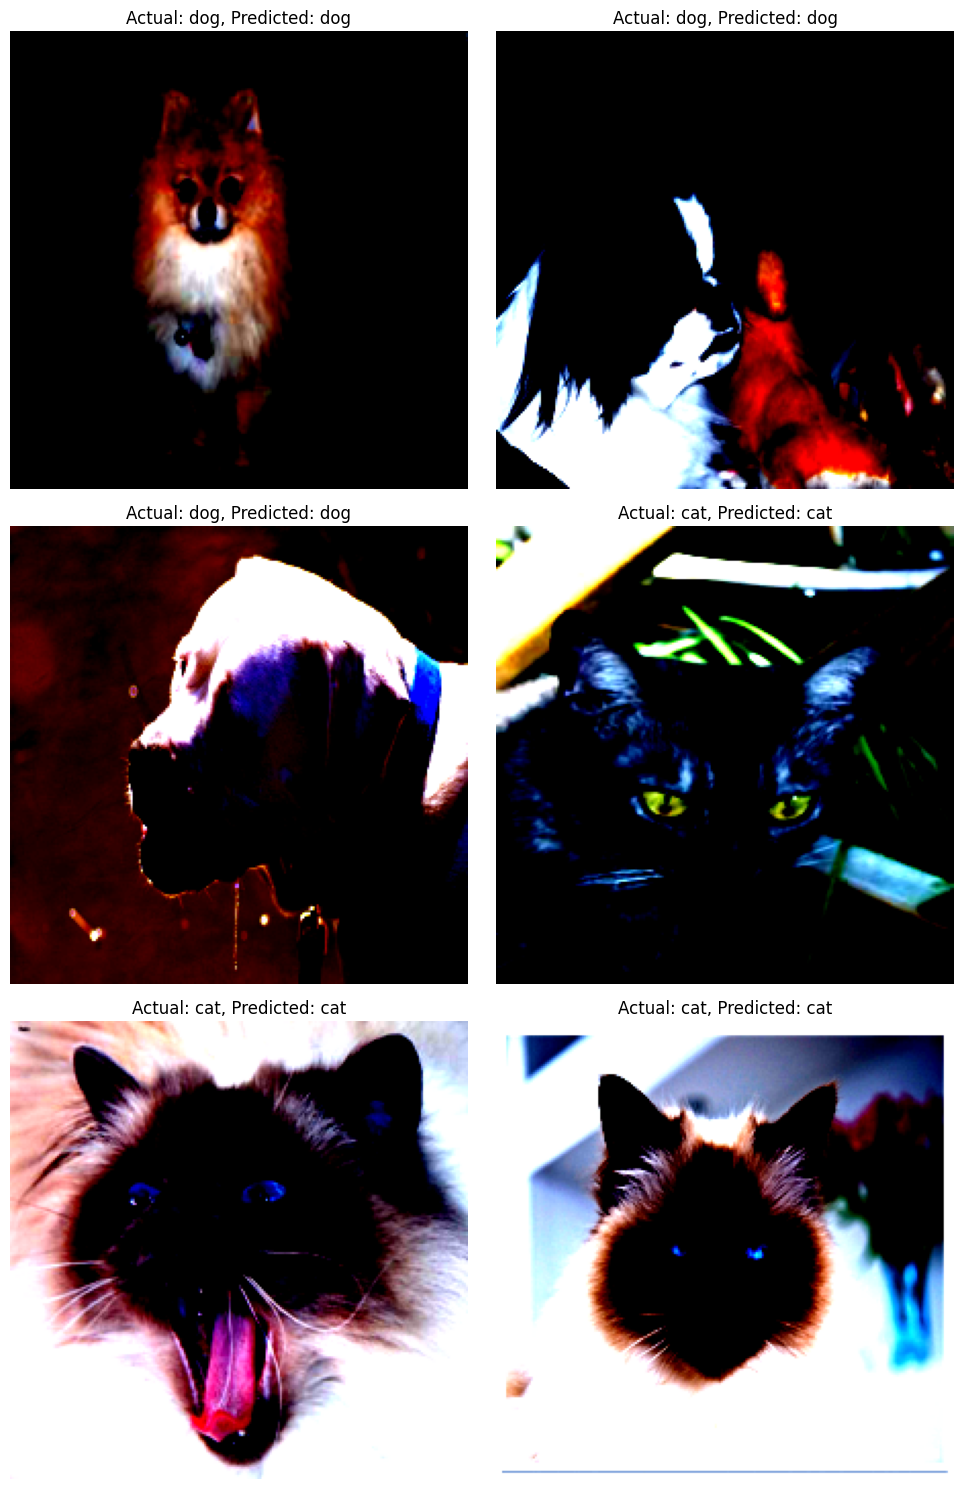

In [14]:
# Function to plot images with labels
def plot_images(images, labels, predictions, nrows=3, ncols=2):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 15))
    axes = axes.flatten()
    for img, lbl, pred, ax in zip(images, labels, predictions, axes):
        ax.imshow(img.permute(1, 2, 0).cpu().numpy())
        ax.set_title(
            f"Actual: {'dog' if lbl == 1 else 'cat'}, Predicted: {'dog' if pred == 1 else 'cat'}"
        )
        ax.axis("off")
    plt.tight_layout()
    plt.show()


# Get a batch of validation data
data_iter = iter(val_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Plot images with labels
plot_images(images[:6], labels[:6], preds[:6])